# Fake News Classication

# Introduction

- Fake news is false or misleading information presented as news. It often has the aim of damaging the reputation of a person or entity, or making money through advertising revenue.
- The prevalence of fake news has increased with the rise of social media, especially the Facebook News Feed. Political polarization, post-truth politics, confirmation bias and social media algorithms have been implicated in the spread of fake news.
- Fake news can reduce the impact of real news by competing with it. As a data scientist, our goal is to harness the good of the information age to catalyze change in society and hopefully progress within this field and likeminded researchers over time will reduce the negatives.
- So, in this project we are going to design a classifier to classify whether a news is fake or not fake.

# Dataset Description

- The dataset has been downloaded from https://www.kaggle.com/c/fake-news/data
- It consist of following :
    - train.csv: A full training dataset with the following attributes:

        1. id: unique id for a news article
        2. title: the title of a news article
        3. author: author of the news article
        4. text: the text of the article; could be incomplete
        5. label: a label that marks the article as potentially unreliable
            - 1: unreliable
            - 0: reliable

    - test.csv: A testing training dataset with all the same attributes at train.csv without the label.

# 1. Importing Dependencies

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sk-learn Libraries 
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Modelling Algorithms
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import classification_report , accuracy_score , confusion_matrix, roc_auc_score
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics

# NLP Libraries
import re
import itertools
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# Other Libraries
import string
from collections import Counter

# Keras Libraries
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
%matplotlib inline

# 2. Data Reading & Analysis

In [2]:
# Reading the data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

## Working with Train Data

In [3]:
# Looking at train data
train_data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
# Shape of train_data dataframe
train_data.shape

(20800, 5)

In [5]:
# Collecting info about the data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


**Observations:**
- It seems there are some null values. Lets pre-process the data

In [6]:
# Computing sum of Null values
train_data.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

**Observations:**
- Here we have two choices:
    1. Remove the NaN entries
    2. Fill the NaN with empty string ' '
- It will be good to choose 2nd choice as if model is trained on a concatenation of the title, the author and the main text, the model would be more generalized because adding more words to the input might increase the reliablity of the model.

In [7]:
# Handling Missing Values
train_data = train_data.fillna(' ')

In [8]:
# Validating
train_data.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [9]:
# Dropping duplicates
train_data.drop_duplicates(inplace = True)

In [10]:
# Create a column with all the data available
train_data['total'] = train_data['title']+' '+train_data['author']+' '+train_data['text']
train_data.head()

,id,title,author,text,label,total
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Consortiumne...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...


In [11]:
## Let's use groupby to use describe by label, this way we can begin to think about the features that separate 
# Fake or Not Fake!

train_data.groupby('label').describe()

id                                                            \
         count          mean          std  min     25%      50%      75%   
label                                                                      
0      10387.0  10392.644171  5982.025154  1.0  5225.5  10396.0  15565.5   
1      10413.0  10406.338711  6027.288133  0.0  5159.0  10403.0  15629.0   

                
           max  
label           
0      20797.0  
1      20799.0

**Observations:**
- Data looks balanced

In [12]:
# Let's make a new column to detect how news are:
train_data['news_length'] = train_data['text'].apply(len)
train_data.head()

,id,title,author,text,label,total,news_length
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...,4930
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",4160
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Consortiumne...,7692
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...,3237
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...,938


In [13]:
# Analysing the 'news_length' feature
train_data['news_length'].describe()

count     20800.000000
mean       4544.180913
std        5129.532125
min           1.000000
25%        1619.000000
50%        3352.000000
75%        6265.500000
max      142961.000000
Name: news_length, dtype: float64

In [14]:
# Max is 142961 characters, let's use masking to find this news
train_data[train_data['news_length'] == 142961]['title'].iloc[0]

'Заседание Международного дискуссионного клуба «Валдай», Владимир В. Путин'

[Text(0.5, 0, 'Length of news'),
 Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'Reliable / Not Fake')]

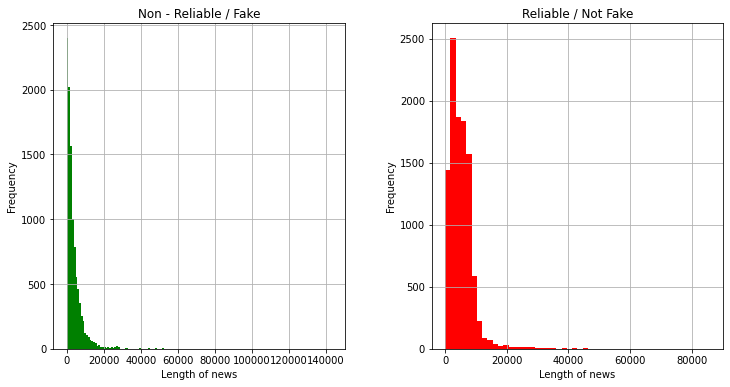

In [15]:
# Lets see if news length is a distinguishing feature between Fake and Not Fake:

fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))

train_data[train_data['label'] == 1].hist(column = 'news_length', bins = 150, ax = ax[0], color = 'green')
ax[0].set(xlabel = 'Length of news', ylabel = 'Frequency', title = 'Non - Reliable / Fake')

train_data[train_data['label'] == 0].hist(column = 'news_length', bins = 50, ax = ax[1], color = 'red')
ax[1].set(xlabel = 'Length of news', ylabel = 'Frequency', title = 'Reliable / Not Fake')

**Observations:**
- As expected Through the basic EDA we've seen that no seperation or trend has observed using 'news_length' feature.

# 3. Pre-processing

- Our main issue with our data is that it is all in text format (strings). The classification algorithms that we've learned about so far will need some sort of numerical feature vector in order to perform the classification task.
- There are actually many methods to convert a corpus to a vector format. The simplest is the the bag-of-words approach, where each unique word in a text will be represented by one number.

## Train-Test Splitting

In [16]:
# Dividing the training set by using train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_data['total'], train_data.label, test_size = 0.20, random_state = 0)

## Vectorizing our Data

### 1. Bag-of-Words (Count Vectorizer)

In [17]:
# Initialize the 'count_vectorizer' 
cv = CountVectorizer(ngram_range = (1, 2), stop_words = 'english')

# fit and transform the training data
count_train = cv.fit_transform(x_train)

# Transform the test data 
count_test = cv.transform(x_test)

In [18]:
print('Shape of Sparse Matrix: ', count_train.shape)
print('Amount of Non-Zero occurences: ', count_train.nnz)

Shape of Sparse Matrix:  (16640, 3922396)
Amount of Non-Zero occurences:  10598929


In [19]:
print('Shape of Sparse Matrix: ', count_test.shape)
print('Amount of Non-Zero occurences: ', count_test.nnz)

Shape of Sparse Matrix:  (4160, 3922396)
Amount of Non-Zero occurences:  1864392


### 2. TF-IDF (TFIDF Vectorizer)

In [20]:
# Initialize the 'tfidf_vectorizer'
tfidf = TfidfVectorizer(ngram_range = (1, 2), stop_words = 'english')

# fit and transform the training data 
tfidf_train = tfidf.fit_transform(x_train)

# transform the test set 
tfidf_test = tfidf.transform(x_test)

In [21]:
print('Shape of Sparse Matrix: ', tfidf_train.shape)
print('Amount of Non-Zero occurences: ', tfidf_train.nnz)

Shape of Sparse Matrix:  (16640, 3922396)
Amount of Non-Zero occurences:  10598929


In [22]:
print('Shape of Sparse Matrix: ', tfidf_test.shape)
print('Amount of Non-Zero occurences: ', tfidf_test.nnz)

Shape of Sparse Matrix:  (4160, 3922396)
Amount of Non-Zero occurences:  1864392


### 3. Pipelined (BOW-TFIDF Transformer)

In [23]:
# Initialize the 'tfidf_transformer'
tv = TfidfTransformer()

# Learn the training data vocabulary, then use it to create a document-term matrix
pipelined_train = tv.fit_transform(count_train)

# Transform test data (using fitted vocabulary) into a document-term matrix
pipelined_test = tv.transform(count_test)

In [24]:
print('Shape of Sparse Matrix: ', pipelined_train.shape)
print('Amount of Non-Zero occurences: ', pipelined_train.nnz)

Shape of Sparse Matrix:  (16640, 3922396)
Amount of Non-Zero occurences:  10598929


In [25]:
print('Shape of Sparse Matrix: ', pipelined_test.shape)
print('Amount of Non-Zero occurences: ', pipelined_test.nnz)

Shape of Sparse Matrix:  (4160, 3922396)
Amount of Non-Zero occurences:  1864392


 # 4. Building and Evaluating a Model

In [26]:
# Defining a function that outputs a confusion matrix

def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues):
    
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment = "center", color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## 1. Multinomial Naive Bayes

### 1.1 Multinomial Naive Bayes with Count Vectorizer (Bag-of-Words)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   14.5s finished


Best Parameters For Multinomial Naive Bayes for Bag-of-Words :  {'alpha': 0.1}
--------------------------------------------------------------------------------------------------------------
Training Accuracy Multinomial for Naive Bayes for Bag-of-Words :
1.0
--------------------------------------------------------------------------------------------------------------
Test Accuracy Multinomial for Naive Bayes for Bag-of-Words :
0.942548076923077
--------------------------------------------------------------------------------------------------------------


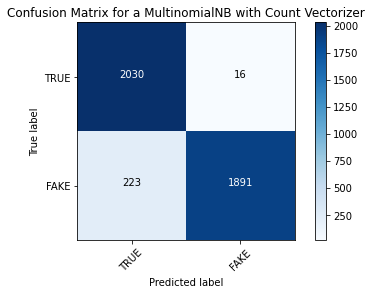

In [27]:
# Tuning Hyper-Parameters
grid_parameters = {'alpha' : [0.01, 0.1, 0.15, 0.2]}

# Instantiate the classifier
nb_classifier_bow = GridSearchCV(MultinomialNB(), grid_parameters, verbose = 1, cv = 3, n_jobs = -1)

# Train the model using count_train
nb_classifier_bow.fit(count_train, y_train)

# Finding best_estimator
nb_classifier_bow_best = nb_classifier_bow.best_estimator_

# Predicting for Test data using count_test
y_pred_nb = nb_classifier_bow_best.predict(count_test)

print ("Best Parameters For Multinomial Naive Bayes for Bag-of-Words : ", nb_classifier_bow.best_params_)
print('-'*110)

# Evaluation
print("Training Accuracy Multinomial for Naive Bayes for Bag-of-Words :")
print(nb_classifier_bow_best.score(count_train, y_train))
print('-'*110)

print("Test Accuracy Multinomial for Naive Bayes for Bag-of-Words :")
print(accuracy_score(y_pred_nb , y_test))
print('-'*110)

# Plotting Confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_nb, labels = [0,1])
plot_confusion_matrix(cm, classes = ['TRUE','FAKE'], title ='Confusion Matrix for a MultinomialNB with Count Vectorizer')

### 1.2 Multinomial Naive Bayes with TF-IDF Vectorizer

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    7.7s finished


Best Parameters For Multinomial Naive Bayes for TFIDF vectorizer :  {'alpha': 0.01}
--------------------------------------------------------------------------------------------------------------
Training Accuracy Multinomial Naive Bayes for TFIDF vectorizer :
1.0
--------------------------------------------------------------------------------------------------------------
Test Accuracy Multinomial Naive Bayes for TFIDF vectorizer :
0.94375
--------------------------------------------------------------------------------------------------------------


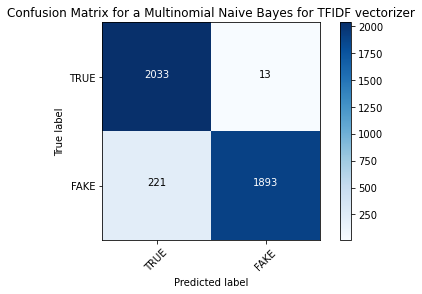

In [28]:
# Tuning Hyper-Parameters
grid_parameters = {'alpha' : [0.01, 0.1, 0.15, 0.2]}

# Instantiate the classifier
nb_classifier_tfidf = GridSearchCV(MultinomialNB(), grid_parameters, verbose = 1, cv = 3, n_jobs = -1)

# Train the model using tfidf_train
nb_classifier_tfidf.fit(tfidf_train, y_train)

# Finding best_estimator
nb_classifier_tfidf_best = nb_classifier_tfidf.best_estimator_

# Predicting for Test data using tfidf_test
y_pred_nb_tfidf = nb_classifier_tfidf_best.predict(tfidf_test)

print ("Best Parameters For Multinomial Naive Bayes for TFIDF vectorizer : ", nb_classifier_tfidf.best_params_)
print('-'*110)

# Evaluation
print("Training Accuracy Multinomial Naive Bayes for TFIDF vectorizer :")
print(nb_classifier_tfidf_best.score(tfidf_train, y_train))
print('-'*110)

print("Test Accuracy Multinomial Naive Bayes for TFIDF vectorizer :")
print(accuracy_score(y_pred_nb_tfidf , y_test))
print('-'*110)

# Plotting Confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_nb_tfidf, labels = [0,1])
plot_confusion_matrix(cm, classes = ['TRUE','FAKE'], title ='Confusion Matrix for a Multinomial Naive Bayes for TFIDF vectorizer')

### 1.3 Multinomial Naive Bayes with Pipelined(BOW-TF-IDF Transformer)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    6.4s finished


Best Parameters For Multinomial Naive Bayes for Pipelined Transformer :  {'alpha': 0.01}
--------------------------------------------------------------------------------------------------------------
Training Accuracy Multinomial Naive Bayes for pipelined Transformer :
1.0
--------------------------------------------------------------------------------------------------------------
Test Accuracy Multinomial Naive Bayes for Pipelined Transformer :
0.94375
--------------------------------------------------------------------------------------------------------------


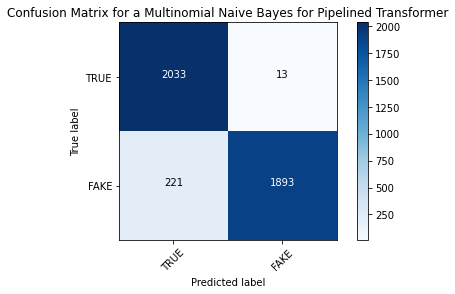

In [29]:
# Tuning Hyper-Parameters
grid_parameters = {'alpha' : [0.01, 0.1, 0.15, 0.2]}

# Instantiate the classifier
nb_classifier_pipelined = GridSearchCV(MultinomialNB(), grid_parameters, verbose = 1, cv = 3, n_jobs = -1)

# Train the model using pipelined_train
nb_classifier_pipelined.fit(pipelined_train, y_train)

# Finding best_estimator
nb_classifier_pipelined_best = nb_classifier_pipelined.best_estimator_

# Predicting for Test data using pipelined_test
y_pred_nb_pipelined = nb_classifier_pipelined_best.predict(pipelined_test)

print ("Best Parameters For Multinomial Naive Bayes for Pipelined Transformer : ", nb_classifier_pipelined.best_params_)
print('-'*110)

# Evaluation
print("Training Accuracy Multinomial Naive Bayes for pipelined Transformer :")
print(nb_classifier_pipelined_best.score(tfidf_train, y_train))
print('-'*110)

print("Test Accuracy Multinomial Naive Bayes for Pipelined Transformer :")
print(accuracy_score(y_pred_nb_pipelined , y_test))
print('-'*110)

# Plotting Confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_nb_pipelined, labels = [0,1])
plot_confusion_matrix(cm, classes = ['TRUE','FAKE'], title ='Confusion Matrix for a Multinomial Naive Bayes for Pipelined Transformer')

## 2. Passive Agressive Classifier

### 2.1 Passive Agressive Classifier With Count Vectorizer (Bag-of-Words)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   19.3s finished


Best Parameters For Passive Agressive Classifier for Bag-of-Words :  {'C': 1}
--------------------------------------------------------------------------------------------------------------
Training Accuracy Passive Agressive Classifier for Bag-of-Words :
1.0
--------------------------------------------------------------------------------------------------------------
Test Accuracy Passive Agressive Classifier for Bag-of-Words :
0.9658653846153846
--------------------------------------------------------------------------------------------------------------


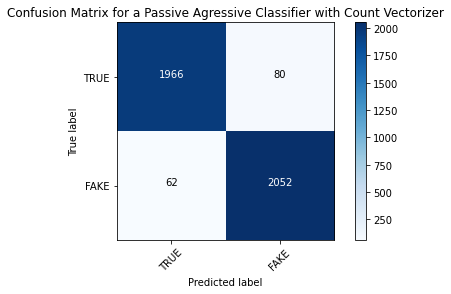

In [30]:
# Tuning Hyper-Parameters
grid_parameters = {'C' : [0.01, 0.1, 0.5, 1]}

# Instantiate the classifier
pac_classifier_bow = GridSearchCV(PassiveAggressiveClassifier(), grid_parameters, verbose = 1, cv = 3, n_jobs = -1)

# Train the model using count_train
pac_classifier_bow.fit(count_train, y_train)

# Finding best_estimator
pac_classifier_bow_best = pac_classifier_bow.best_estimator_

# Predicting for Test data using count_test
y_pred_pac = pac_classifier_bow_best.predict(count_test)

print ("Best Parameters For Passive Agressive Classifier for Bag-of-Words : ", pac_classifier_bow.best_params_)
print('-'*110)

# Evaluation
print("Training Accuracy Passive Agressive Classifier for Bag-of-Words :")
print(pac_classifier_bow_best.score(count_train, y_train))
print('-'*110)

print("Test Accuracy Passive Agressive Classifier for Bag-of-Words :")
print(accuracy_score(y_pred_pac , y_test))
print('-'*110)

# Plotting Confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_pac, labels = [0,1])
plot_confusion_matrix(cm, classes = ['TRUE','FAKE'], title ='Confusion Matrix for a Passive Agressive Classifier with Count Vectorizer')

### 2.2 Passive Agressive Classifier With TFIDF Vectorizer

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   19.3s finished


Best Parameters For Passive Agressive Classifier With TFIDF Vectorizer :  {'C': 1}
--------------------------------------------------------------------------------------------------------------
Training Accuracy for Passive Agressive Classifier With TFIDF Vectorizer :
1.0
--------------------------------------------------------------------------------------------------------------
Test Accuracy for Passive Agressive Classifier With TFIDF Vectorizer :
0.979326923076923
--------------------------------------------------------------------------------------------------------------


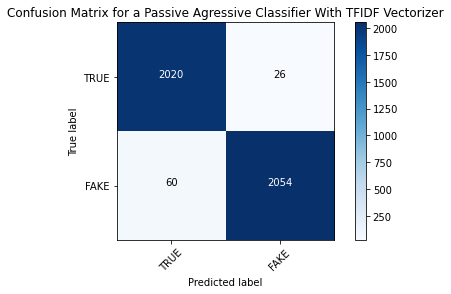

In [31]:
# Tuning Hyper-Parameters
grid_parameters = {'C' : [0.01, 0.1, 0.5, 1, 1.5]}

# Instantiate the classifier
pact_classifier_tfidf = GridSearchCV(PassiveAggressiveClassifier(), grid_parameters, verbose = 1, cv = 3, n_jobs = -1)

# Train the model using tfidf_train
pact_classifier_tfidf.fit(tfidf_train, y_train)

# Finding best_estimator
pact_classifier_tfidf_best = pact_classifier_tfidf.best_estimator_

# Predicting for Test data using tfidf_test
y_pred_pact_tfidf = pact_classifier_tfidf_best.predict(tfidf_test)

print ("Best Parameters For Passive Agressive Classifier With TFIDF Vectorizer : ", pact_classifier_tfidf.best_params_)
print('-'*110)

# Evaluation
print("Training Accuracy for Passive Agressive Classifier With TFIDF Vectorizer :")
print(pact_classifier_tfidf_best.score(tfidf_train, y_train))
print('-'*110)

print("Test Accuracy for Passive Agressive Classifier With TFIDF Vectorizer :")
print(accuracy_score(y_pred_pact_tfidf , y_test))
print('-'*110)

# Plotting Confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_pact_tfidf, labels = [0,1])
plot_confusion_matrix(cm, classes = ['TRUE','FAKE'], title ='Confusion Matrix for a Passive Agressive Classifier With TFIDF Vectorizer')

### 2.3 Passive Agressive Classifier With Pipelined (BOW-TFIDF Transformer)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   19.4s finished


Best Parameters For Passive Agressive Classifier With Pipelined Transformer :  {'C': 0.1}
--------------------------------------------------------------------------------------------------------------
Training Accuracy Passive Agressive Classifier With Pipelined Transformer :
0.9999399038461538
--------------------------------------------------------------------------------------------------------------
Test Accuracy Passive Agressive Classifier With Pipelined Transformer :
0.9802884615384615
--------------------------------------------------------------------------------------------------------------


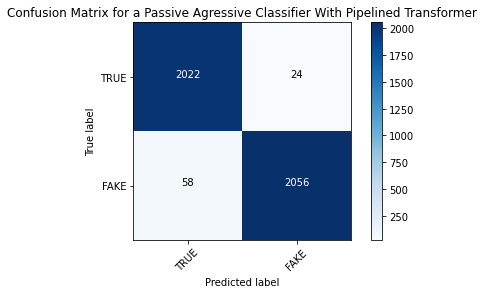

In [32]:
# Tuning Hyper-Parameters
grid_parameters = {'C' : [0.01, 0.1, 0.5, 1, 1.5]}

# Instantiate the classifier
pacp_classifier_pipelined = GridSearchCV(PassiveAggressiveClassifier(), grid_parameters, verbose = 1, cv = 3, n_jobs = -1)

# Train the model using pipelined_train
pacp_classifier_pipelined.fit(pipelined_train, y_train)

# Finding best_estimator
pacp_classifier_pipelined_best = pacp_classifier_pipelined.best_estimator_

# Predicting for Test data using pipelined_test
y_pred_pacp_pipelined = pacp_classifier_pipelined_best.predict(pipelined_test)

print ("Best Parameters For Passive Agressive Classifier With Pipelined Transformer : ", pacp_classifier_pipelined.best_params_)
print('-'*110)

# Evaluation
print("Training Accuracy Passive Agressive Classifier With Pipelined Transformer :")
print(pacp_classifier_pipelined_best.score(tfidf_train, y_train))
print('-'*110)

print("Test Accuracy Passive Agressive Classifier With Pipelined Transformer :")
print(accuracy_score(y_pred_pacp_pipelined , y_test))
print('-'*110)

# Plotting Confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_pacp_pipelined, labels = [0,1])
plot_confusion_matrix(cm, classes = ['TRUE','FAKE'], title ='Confusion Matrix for a Passive Agressive Classifier With Pipelined Transformer')

## 3.  Logistic Regression

### 3.1 Logistic Regression with CountVectorizer (Bag-of-Words)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 12.7min finished
C:\Users\sami\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Best Parameters For Logistic Regression for Bag-of-Words :  {'C': 1.5, 'penalty': 'l2'}
--------------------------------------------------------------------------------------------------------------
Training Accuracy for Logistic Regression for Bag-of-Words :
1.0
--------------------------------------------------------------------------------------------------------------
Test Accuracy for Logistic Regression for Bag-of-Words :
0.9788461538461538
--------------------------------------------------------------------------------------------------------------


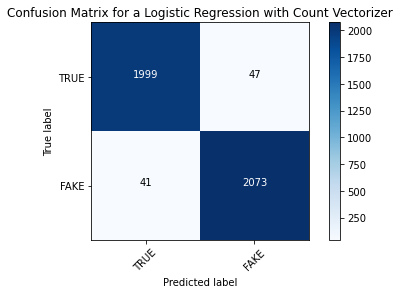

In [33]:
# Tuning Hyper-Parameters
grid_parameters = {'C' : [0.01, 0.1, 0.5, 1, 1.5], 'penalty': ['l1','l2']}

# Instantiate the classifier
lr_classifier_bow = GridSearchCV(LogisticRegression(), grid_parameters, verbose = 1, cv = 3, n_jobs = -1)

# Train the model using count_train
lr_classifier_bow.fit(count_train, y_train)

# Finding best_estimator
lr_classifier_bow_best = lr_classifier_bow.best_estimator_

# Predicting for Test data using count_test
y_pred_lr = lr_classifier_bow_best.predict(count_test)

print ("Best Parameters For Logistic Regression for Bag-of-Words : ", lr_classifier_bow.best_params_)
print('-'*110)

# Evaluation
print("Training Accuracy for Logistic Regression for Bag-of-Words :")
print(lr_classifier_bow_best.score(count_train, y_train))
print('-'*110)

print("Test Accuracy for Logistic Regression for Bag-of-Words :")
print(accuracy_score(y_pred_lr , y_test))
print('-'*110)

# Plotting Confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_lr, labels = [0,1])
plot_confusion_matrix(cm, classes = ['TRUE','FAKE'], title ='Confusion Matrix for a Logistic Regression with Count Vectorizer')

### 3.2 Logistic Regression with TFIDF Vectorizer

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  5.0min finished


Best Parameters For Logistic Regression With TFIDF Vectorizer :  {'C': 1.5, 'penalty': 'l2'}
--------------------------------------------------------------------------------------------------------------
Training Accuracy for Logistic Regression With TFIDF Vectorizer :
0.9923076923076923
--------------------------------------------------------------------------------------------------------------
Test Accuracy for Logistic Regression With TFIDF Vectorizer :
0.9644230769230769
--------------------------------------------------------------------------------------------------------------


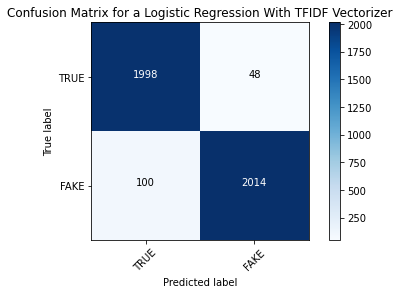

In [34]:
# Tuning Hyper-Parameters
grid_parameters = {'C' : [0.01, 0.1, 0.5, 1, 1.5], 'penalty': ['l1','l2']}

# Instantiate the classifier
lrt_classifier_tfidf = GridSearchCV(LogisticRegression(), grid_parameters, verbose = 1, cv = 3, n_jobs = -1)

# Train the model using tfidf_train
lrt_classifier_tfidf.fit(tfidf_train, y_train)

# Finding best_estimator
lrt_classifier_tfidf_best = lrt_classifier_tfidf.best_estimator_

# Predicting for Test data using tfidf_test
y_pred_lrt_tfidf = lrt_classifier_tfidf_best.predict(tfidf_test)

print ("Best Parameters For Logistic Regression With TFIDF Vectorizer : ", lrt_classifier_tfidf.best_params_)
print('-'*110)

# Evaluation
print("Training Accuracy for Logistic Regression With TFIDF Vectorizer :")
print(lrt_classifier_tfidf_best.score(tfidf_train, y_train))
print('-'*110)

print("Test Accuracy for Logistic Regression With TFIDF Vectorizer :")
print(accuracy_score(y_pred_lrt_tfidf , y_test))
print('-'*110)

# Plotting Confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_lrt_tfidf, labels = [0,1])
plot_confusion_matrix(cm, classes = ['TRUE','FAKE'], title ='Confusion Matrix for a Logistic Regression With TFIDF Vectorizer')

### 3.3 Logistic Regression with Pipelined (BOW-TFIDF Transformer)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  9.9min finished


Best Parameters For Logistic Regression With Pipelined Transformer :  {'C': 1.5, 'penalty': 'l2'}
--------------------------------------------------------------------------------------------------------------
Training Accuracy for Logistic Regression With Pipelined Transformer :
0.9923076923076923
--------------------------------------------------------------------------------------------------------------
Test Accuracy for Logistic Regression With Pipelined Transformer :
0.9644230769230769
--------------------------------------------------------------------------------------------------------------


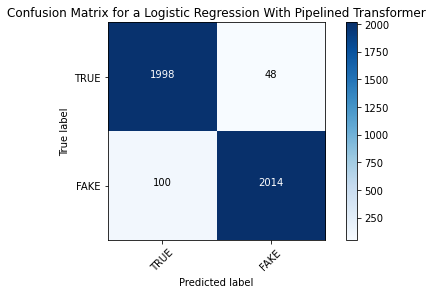

In [35]:
# Tuning Hyper-Parameters
grid_parameters = {'C' : [0.01, 0.1, 0.5, 1, 1.5], 'penalty': ['l1','l2']}

# Instantiate the classifier
lrp_classifier_pipelined = GridSearchCV(LogisticRegression(), grid_parameters, verbose = 1, cv = 3, n_jobs = -1)

# Train the model using pipelined_train
lrp_classifier_pipelined.fit(pipelined_train, y_train)

# Finding best_estimator
lrp_classifier_pipelined_best = lrp_classifier_pipelined.best_estimator_

# Predicting for Test data using pipelined_test
y_pred_lrp_pipelined = lrp_classifier_pipelined_best.predict(pipelined_test)

print ("Best Parameters For Logistic Regression With Pipelined Transformer : ", lrp_classifier_pipelined.best_params_)
print('-'*110)

# Evaluation
print("Training Accuracy for Logistic Regression With Pipelined Transformer :")
print(lrp_classifier_pipelined_best.score(tfidf_train, y_train))
print('-'*110)

print("Test Accuracy for Logistic Regression With Pipelined Transformer :")
print(accuracy_score(y_pred_lrp_pipelined , y_test))
print('-'*110)

# Plotting Confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_lrp_pipelined, labels = [0,1])
plot_confusion_matrix(cm, classes = ['TRUE','FAKE'], title ='Confusion Matrix for a Logistic Regression With Pipelined Transformer')

## Conclusions For Machine Learning Algorithms

- We get highest Accuracy with **Passive Agressive Classifier With Pipelined (BOW-TFIDF Transformer)** about 98.02% on test data. But when we analyse confusion matrix we have more number of fake news labeled as true news i.e. 58.
- We get good Accuracy with **Logistic Regression with CountVectorizer (Bag-of-Words)** about 97.88% on test data. Even though the accuracy score is a bit lower, we have less fake news labeled as true news ie. only 41. 
- Therefore, this model can be chosen for Submitting the actual test file because it seems to maximize the accuracy while minimizing the false negative rate!
- But yet before reaching to final conclusion lets analyze by using Deep Learning Techniques

## 4. LSTMs

In [36]:
# Lets copy the original data into new variable
new_train_data = train_data.copy()
new_train_data.head()

,id,title,author,text,label,total,news_length
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...,4930
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",4160
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Consortiumne...,7692
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...,3237
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...,938


In [37]:
# Lets sort the news based on 'news_length'
new_train_data.sort_values(by = 'news_length', inplace = True)
new_train_data

,id,title,author,text,label,total,news_length
9663,9663,A Virginia Reader Writes On The Astounding Chu...,VDARE.com Reader,,1,A Virginia Reader Writes On The Astounding Chu...,1
19157,19157,110% des Américains assurent qu’ils continuero...,,,1,110% des Américains assurent qu’ils continuero...,1
17819,17819,"James Bowman: “Vote For The Creep, It’s Import...",James Fulford,,1,"James Bowman: “Vote For The Creep, It’s Import...",1
14933,14933,La sortie du dernier livre inédit du Gorafi éc...,,,1,La sortie du dernier livre inédit du Gorafi éc...,1
1200,1200,La Corée du Nord annonce avoir envoyé un missi...,,,1,La Corée du Nord annonce avoir envoyé un missi...,1
...,...,...,...,...,...,...,...
14293,14293,Re: It Is Now Mathematically Impossible To Pay...,Don,It Is Now Mathematically Impossible To Pay Off...,1,Re: It Is Now Mathematically Impossible To Pay...,99355
8719,8719,Re: How Many People Will Have To Migrate Out O...,Get it right,How Many People Will Have To Migrate Out Of Ca...,1,Re: How Many People Will Have To Migrate Out O...,115010
7530,7530,Re: Why Are So Many People Choosing To Leave T...,BOOTOUTTHEBULLIES,Why Are So Many People Choosing To Leave The U...,1,Re: Why Are So Many People Choosing To Leave T...,115372
13533,13533,Re: The Hard Working American vs. The Governme...,Janet Witt,The Hard Working American vs. The Government P...,1,Re: The Hard Working American vs. The Governme...,134206


**Note:**
- As the Lengths of 'text' i.e description of news is in lakhs of words so due to lack of computational resources we will restrict our analysis to only 'title' column.

In [38]:
# Lets copy the original data into new variable
new_train_data = train_data.copy()
new_train_data.head()

,id,title,author,text,label,total,news_length
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...,4930
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",4160
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Consortiumne...,7692
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...,3237
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...,938


In [39]:
# Considering only One Feature i.e 'title' as author will not make sense initially.
x = new_train_data['title']
y = new_train_data['label']

In [40]:
x.shape

(20800,)

In [41]:
y.shape

(20800,)

### Pre-processing

In [42]:
ps = PorterStemmer()
corpus = []
for i in range(0, len(new_train_data)):
    
    
    title = re.sub('[^a-zA-Z]', ' ', new_train_data['title'][i])
    title = title.lower()
    title = title.split()
    
    STOPWORDS = set(stopwords.words('english')) - set(['not', "aren't", "couldn't", "didn't", "doesn't", "don't"
                                                       "hadn't", "haven't", "isn't", "shan't", "needn't", "shouldn't"
                                                       "wasn't", "wouldn't"])
    
    
    title = [word for word in title if not word in STOPWORDS]
    title = ' '.join(title)
    corpus.append(title)

In [43]:
# Lets look for some news title
corpus[0]

'house dem aide even see comey letter jason chaffetz tweeted'

In [44]:
corpus[30]

'chuck todd buzzfeed eic published fake news breitbart'

In [45]:
# Consider vocabulory size as 7000
vocab_size = 7000

# Lets perform one hot representation
one_hot_encode = [one_hot(words, vocab_size)for words in corpus]

In [46]:
# Consider length of first title
len(one_hot_encode[0])

10

In [47]:
# Here we are specifying a sentence length so that each sentence in the corpus will be of same length. Consider 30 arbitarily

sentence_length = 30

# Lets perform padding for creating equal length sentences
embedded_titles = pad_sequences(one_hot_encode, padding = 'pre', maxlen = sentence_length)
print(embedded_titles)

[[   0    0    0 ... 4944 3444 6218]
 [   0    0    0 ... 5184  838 5410]
 [   0    0    0 ... 2637 2968  548]
 ...
 [   0    0    0 ... 6407  532 1346]
 [   0    0    0 ... 2020 6410 1810]
 [   0    0    0 ... 5525 3207 2073]]


## Train - Test Splitting

In [48]:
z = np.array(embedded_titles)
y = np.array(y)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(z, y, test_size = 0.20, random_state = 1)

## Modeling

In [50]:
# Initializing the Model
model = Sequential()

# Adding Embedded Layer
model.add(Embedding(input_dim = vocab_size, output_dim = 100, input_length = sentence_length))
# Adding Dropout Layer
model.add(Dropout(0.3))

# Adding LSTM Layer
model.add(LSTM(200))
# Adding Dropout Layer
model.add(Dropout(0.3))

# Fully Connected Layer
model.add(Dense(1, activation = 'sigmoid'))

# Compiling the Model
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           700000    
_________________________________________________________________
dropout (Dropout)            (None, 30, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 200)               240800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 941,001
Trainable params: 941,001
Non-trainable params: 0
_________________________________________________________________


In [52]:
model_result = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 20, batch_size = 64, workers = -1)

Epoch 1/20
260/260 [==============================] - 23s 88ms/step - loss: 0.2612 - accuracy: 0.8922 - val_loss: 0.1698 - val_accuracy: 0.9310
Epoch 2/20
260/260 [==============================] - 22s 83ms/step - loss: 0.1174 - accuracy: 0.9546 - val_loss: 0.1697 - val_accuracy: 0.9349
Epoch 3/20
260/260 [==============================] - 23s 88ms/step - loss: 0.0627 - accuracy: 0.9776 - val_loss: 0.2069 - val_accuracy: 0.9260
Epoch 4/20
260/260 [==============================] - 23s 90ms/step - loss: 0.0303 - accuracy: 0.9899 - val_loss: 0.2582 - val_accuracy: 0.9221
Epoch 5/20
260/260 [==============================] - 21s 80ms/step - loss: 0.0174 - accuracy: 0.9942 - val_loss: 0.3082 - val_accuracy: 0.9276
Epoch 6/20
260/260 [==============================] - 22s 83ms/step - loss: 0.0102 - accuracy: 0.9968 - val_loss: 0.4055 - val_accuracy: 0.9178
Epoch 7/20
260/260 [==============================] - 24s 92ms/step - loss: 0.0074 - accuracy: 0.9977 - val_loss: 0.3726 - val_accuracy:

In [54]:
model_evaluation = model.evaluate(X_test, y_test)
print('Test Loss is : {} and the Test Accuracy is: {}'.format(model_evaluation[0], model_evaluation[1]))

130/130 [==============================] - 2s 13ms/step - loss: 0.6160 - accuracy: 0.9144
Test Loss is : 0.6160457134246826 and the Test Accuracy is: 0.9144230484962463


In [55]:
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors = ['b']):
    ax.plot(x, vy, 'b', label = "Validation Loss")
    ax.plot(x, ty, 'r', label = "Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

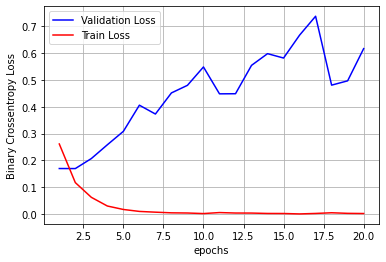

In [56]:
# Plotting Train & Validation Loss
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epochs') 
ax.set_ylabel('Binary Crossentropy Loss')

# list of epoch numbers
p = list(range(1, 21))
vy = model_result.history['val_loss']
ty = model_result.history['loss']

# Calling Function
plt_dynamic(p, vy, ty, ax)

**Observations:**
- As seen from the above graph, our model is overfitting due to usage of only one Feature & limited vocab. Yet we have achieved the accuracy about 92.67% which is not bad.
- If we utilized all the features then we could hope for better results. For now lets stop here.

# End Results

- We get highest Accuracy with **Passive Agressive Classifier With Pipelined (BOW-TFIDF Transformer)** about 98.02% on test data. But when we analyse confusion matrix we have more number of fake news labeled as true news i.e. 58.
- We get good Accuracy with **Logistic Regression with CountVectorizer (Bag-of-Words)** about 97.88% on test data. Even though the accuracy score is a bit lower, we have less fake news labeled as true news ie. only 41. 
- Therefore, this model can be chosen for Submitting the actual test file because it seems to maximize the accuracy while minimizing the false negative rate!

# Working with Test Data

In [57]:
# Looking at test data
test_data.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [58]:
# Shape of train_data dataframe
test_data.shape

(5200, 4)

In [59]:
# Computing sum of Null values
test_data.isnull().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [60]:
# Handling Missing Values
test_data = test_data.fillna(' ')

In [61]:
test_data.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [62]:
# Dropping duplicates
test_data.drop_duplicates(inplace = True)

In [63]:
# Create a column with all the data available
test_data['total'] = test_data['title']+' '+test_data['author']+' '+test_data['text']
test_data.head()

,id,title,author,text,total
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...","Specter of Trump Loosens Tongues, if Not Purse..."
1,20801,Russian warships ready to strike terrorists ne...,,Russian warships ready to strike terrorists ne...,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,#NoDAPL: Native American Leaders Vow to Stay A...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...","Tim Tebow Will Attempt Another Comeback, This ..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,Keiser Report: Meme Wars (E995) Truth Broadcas...


In [64]:
test = test_data['total']

In [65]:
# Initialize the 'count_vectorizer' 
cv = CountVectorizer(ngram_range = (1, 2), stop_words = 'english')

# fit and transform the training data
count_train = cv.fit_transform(x_train)

# Transform the test data 
test_bow = cv.transform(test)

In [66]:
print('Shape of Sparse Matrix: ', count_train.shape)
print('Amount of Non-Zero occurences: ', count_train.nnz)

Shape of Sparse Matrix:  (16640, 3922396)
Amount of Non-Zero occurences:  10598929


In [67]:
print('Shape of Sparse Matrix: ', test_bow.shape)
print('Amount of Non-Zero occurences: ', test_bow.nnz)

Shape of Sparse Matrix:  (5200, 3922396)
Amount of Non-Zero occurences:  2379234


In [68]:
pred_test_data = lr_classifier_bow_best.predict(test_bow)

In [69]:
final_submission = test_data
final_submission['Predicted_Label'] = pred_test_data
final_submission.to_csv('Fake_News_Prediction.csv', index = False)

# End of File